In [19]:
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpStatus, LpMinimize

# Sample regression models for tier0 and tier1. Here, we are simply returning fixed bandwidths for simplicity.
def tier0_model(phase):
    return 100e6

def tier1_model(phase):
    return 200e6

# Job and phase data in Python dictionaries
job1_representation = {
    "node_count": 1, "events": [0, 1, 2], "read_volumes": [883728, 0, 0],
    "read_bw": [441864.0, 0, 0], "write_volumes": [0, 9011355062, 0], "write_bw": [0, 819214096.5454545, 0],
    "read_pattern": ["Uncl", "Uncl", "Uncl"], "write_pattern": ["Uncl", "Str", "Uncl"],
    "read_operations": [22, 0, 0], "write_operations": [0, 1016, 0]
}

job1_phase_features = [
    {"job_id": "371903", "nodes": 1, "read_volume": 883728, "write_volume": 0, "read_io_pattern": "uncl",
     "write_io_pattern": "uncl", "read_io_size": 40169.454545454544, "write_io_size": 0, "ioi_bw": 88372.8},
    {"job_id": "371903", "nodes": 1, "read_volume": 0, "write_volume": 9011355062, "read_io_pattern": "uncl",
     "write_io_pattern": "str", "read_io_size": 0, "write_io_size": 8869443.958661417, "ioi_bw": 163842819.3090909},
    {"job_id": "371903", "nodes": 1, "read_volume": 0, "write_volume": 0, "read_io_pattern": "uncl",
     "write_io_pattern": "uncl", "read_io_size": 0, "write_io_size": 0, "ioi_bw": 0.0}
]

job2_representation = {
    "node_count": 1, "events": [0, 1], "read_volumes": [849622, 19210],
    "read_bw": [424811.0, 19210.0], "write_volumes": [0, 9053429170], "write_bw": [0, 754452430.8333334],
    "read_pattern": ["Uncl", "Uncl"], "write_pattern": ["Uncl", "Str"], "read_operations": [13, 11], "write_operations": [0, 1022]
}

job2_phase_features = [
    {"job_id": "371904", "nodes": 1, "read_volume": 849622, "write_volume": 0, "read_io_pattern": "uncl",
     "write_io_pattern": "uncl", "read_io_size": 65355.53846153846, "write_io_size": 0, "ioi_bw": 84962.2},
    {"job_id": "371904", "nodes": 1, "read_volume": 19210, "write_volume": 9053429170, "read_io_pattern": "uncl",
     "write_io_pattern": "str", "read_io_size": 1746.3636363636363, "write_io_size": 8858541.26223092, "ioi_bw": 150894328.1666667}
]

from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Define regression models for tier0 and tier1. For simplicity, we use fixed bandwidths.
def tier0_model(phase):
    return 100e6

def tier1_model(phase):
    return 200e6

# Define the pulp problem
prob = LpProblem("Job_Scheduling", LpMinimize)

# Define jobs and phases in Python dictionaries
jobs = {'job1': job1_representation, 'job2': job2_representation}
phases = {'job1': job1_phase_features, 'job2': job2_phase_features}

# Define decision variables
x = {(job, i): LpVariable(f"x_{job}_{i}", 0) for job, phase_list in phases.items() for i in range(len(phase_list))}
y = {(job, i): LpVariable(f"y_{job}_{i}", 0) for job, phase_list in phases.items() for i in range(len(phase_list))}
z = {(job, i, k): LpVariable(f"z_{job}_{i}_{k}", 0, 1, cat='Binary') for job, phase_list in phases.items() for i in range(len(phase_list)) for k in [0, 1]}

# Objective function: Minimize the maximum end time among all jobs and phases
prob += lpSum(y.values()), "Minimize_Max_EndTime"

sequential  = True
# Define constraints
for job, phase_list in phases.items():
    for i, phase in enumerate(phase_list):
        # Constraint: Each phase should start after the end of the previous phase
        if i > 0:
            prob += x[job, i] >= y[job, i - 1], f"StartAfterPrev_{job}_{i}"
        
        # Constraint: End time is the start time plus the duration, which is calculated based on the sum of read and write volumes and bandwidth
        total_volume = phase['read_volume'] + phase['write_volume']
        bandwidth = tier0_model(phase) if z[job, i, 0] == 1 else tier1_model(phase)
        prob += y[job, i] == x[job, i] + total_volume / bandwidth, f"EndTime_{job}_{i}"

        # Constraint: Only one tier should be selected for each phase
        prob += z[job, i, 0] + z[job, i, 1] == 1, f"SingleTier_{job}_{i}"
        
        # Additional Constraint for Sequential Execution
        if sequential and job == 'job2' and i == 0:
            last_phase_job1 = len(phases['job1']) - 1
            prob += x['job2', 0] >= y['job1', last_phase_job1], "Sequential_Execution"

# Solve the problem
prob.solve()

# Display the results
scheduling_results = {}
for job, phase_list in phases.items():
    scheduling_results[job] = []
    for i in range(len(phase_list)):
        scheduling_results[job].append((x[job, i].varValue, y[job, i].varValue))

print(scheduling_results)
plot_gantt(None, phases, scheduling_results)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home_nfs/mimounis/iosea-venv/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/0519924fc6574ae284d995c2f39a3d3b-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/0519924fc6574ae284d995c2f39a3d3b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 19 COLUMNS
At line 73 RHS
At line 88 BOUNDS
At line 99 ENDATA
Problem MODEL has 14 rows, 20 columns and 28 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 451.05 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 451.05 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and cr

In [23]:
import plotly.graph_objects as go

def plot_gantt(start_end_times, phases_details):
    fig = go.Figure()

    for i, (job_name, phases) in enumerate(start_end_times.items()):
        for j, (start_time, end_time) in enumerate(phases):
            phase = phases_details[job_name][j]
            total_volume = phase['read_volume'] + phase['write_volume']
            if (end_time - start_time) > 0:
                height = total_volume / (end_time - start_time)  # Normalizing for better visualization
            read_ratio = phase['read_volume'] / total_volume if total_volume > 0 else 0
            write_ratio = phase['write_volume'] / total_volume if total_volume > 0 else 0
            color = f'rgba({int(255 * write_ratio)}, {int(255 * read_ratio)}, 255, 0.6)'

            fig.add_shape(type="rect",
                          x0=start_time,
                          x1=end_time,
                          y0=i - height / 2,
                          y1=i + height / 2,
                          line=dict(color=color),
                          fillcolor=color,
                          name=f"{job_name}_Phase_{j}")

            fig.add_annotation(
                x=start_time,
                y=i,
                text=f"{job_name}_Phase_{j}",
                showarrow=False,
                font=dict(size=10)
            )

    fig.update_layout(
        title='Job Execution Gantt Chart',
        xaxis=dict(title='Time (s)'),
        yaxis=dict(title='Jobs'),
        showlegend=False
    )

    fig.show()

# Sample start and end times calculated from the MILP model
start_end_times = {
    'job1': [(0.0, 0.00883728), (0.00883728, 90.122388), (90.122388, 90.122388)],
    'job2': [(90.122388, 90.130884), (90.130884, 180.66537)]
}

# Your job and phase details go here
job1_phase_features = [
    {"read_volume": 883728, "write_volume": 0},
    {"read_volume": 0, "write_volume": 9011355062},
    {"read_volume": 0, "write_volume": 0}
]

job2_phase_features = [
    {"read_volume": 849622, "write_volume": 0},
    {"read_volume": 19210, "write_volume": 9053429170}
]

phases_details = {'job1': job1_phase_features, 'job2': job2_phase_features}

# Plot the Gantt chart
plot_gantt(start_end_times, phases_details)


In [6]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Sample regression models for tier0 and tier1. Here, we are simply returning fixed bandwidths for simplicity.
def tier0_model(phase):
    return 100e6

def tier1_model(phase):
    return 200e6

# Job and phase data in Python dictionaries
job1_representation = {
    "node_count": 1, "events": [0, 1, 2], "read_volumes": [883728, 0, 0],
    "read_bw": [441864.0, 0, 0], "write_volumes": [0, 9011355062, 0], "write_bw": [0, 819214096.5454545, 0],
    "read_pattern": ["Uncl", "Uncl", "Uncl"], "write_pattern": ["Uncl", "Str", "Uncl"],
    "read_operations": [22, 0, 0], "write_operations": [0, 1016, 0]
}

job1_phase_features = [
    {"job_id": "371903", "nodes": 1, "read_volume": 883728, "write_volume": 0, "read_io_pattern": "uncl",
     "write_io_pattern": "uncl", "read_io_size": 40169.454545454544, "write_io_size": 0, "ioi_bw": 88372.8},
    {"job_id": "371903", "nodes": 1, "read_volume": 0, "write_volume": 9011355062, "read_io_pattern": "uncl",
     "write_io_pattern": "str", "read_io_size": 0, "write_io_size": 8869443.958661417, "ioi_bw": 163842819.3090909},
    {"job_id": "371903", "nodes": 1, "read_volume": 0, "write_volume": 0, "read_io_pattern": "uncl",
     "write_io_pattern": "uncl", "read_io_size": 0, "write_io_size": 0, "ioi_bw": 0.0}
]

job2_representation = {
    "node_count": 1, "events": [0, 1], "read_volumes": [849622, 19210],
    "read_bw": [424811.0, 19210.0], "write_volumes": [0, 9053429170], "write_bw": [0, 754452430.8333334],
    "read_pattern": ["Uncl", "Uncl"], "write_pattern": ["Uncl", "Str"], "read_operations": [13, 11], "write_operations": [0, 1022]
}

job2_phase_features = [
    {"job_id": "371904", "nodes": 1, "read_volume": 849622, "write_volume": 0, "read_io_pattern": "uncl",
     "write_io_pattern": "uncl", "read_io_size": 65355.53846153846, "write_io_size": 0, "ioi_bw": 84962.2},
    {"job_id": "371904", "nodes": 1, "read_volume": 19210, "write_volume": 9053429170, "read_io_pattern": "uncl",
     "write_io_pattern": "str", "read_io_size": 1746.3636363636363, "write_io_size": 8858541.26223092, "ioi_bw": 150894328.1666667}
]
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Define the pulp problem
prob = LpProblem("Job_Scheduling", LpMinimize)

# Define the jobs and phases
jobs = {'job1': job1_representation, 'job2': job2_representation}
phases = {'job1': job1_phase_features, 'job2': job2_phase_features}

# Define the decision variables
# Start time of each phase for each job
x = {(job, i): LpVariable(f"x_{job}_{i}", 0) for job, phase_list in phases.items() for i in range(len(phase_list))}
# End time of each phase for each job
y = {(job, i): LpVariable(f"y_{job}_{i}", 0) for job, phase_list in phases.items() for i in range(len(phase_list))}

# Objective function: Minimize the maximum end time among all jobs and phases
prob += lpSum(y.values()), "Minimize_Max_EndTime"

# Constraints for each job
for job, phase_list in phases.items():
    for i in range(len(phase_list)):
        # Each phase should start after the end of the previous phase
        if i > 0:
            prob += x[job, i] >= y[job, i - 1], f"StartAfterPrev_{job}_{i}"
        
        # End time is the start time plus the calculated duration (Let's use 'ioi_bw' for demonstration)
        # For a more accurate model, you should use a regression model to estimate the duration
        prob += y[job, i] == x[job, i] + phase_list[i]['ioi_bw'], f"EndTime_{job}_{i}"

# Solve the problem
prob.solve()

# Print the results
for job, phase_list in phases.items():
    print(f"Scheduling for {job}:")
    for i in range(len(phase_list)):
        print(f"  Phase {i}: Start at {x[job, i].varValue}, End at {y[job, i].varValue}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home_nfs/mimounis/iosea-venv/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1f10c27c397d415a8837fc6387398d6b-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/1f10c27c397d415a8837fc6387398d6b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 35 RHS
At line 44 BOUNDS
At line 45 ENDATA
Problem MODEL has 8 rows, 10 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-8) rows, 0 (-10) columns and 0 (-16) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 4.7901501e+08
After Postsolve, objective 4.7901501e+08, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 479015009.6 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wal

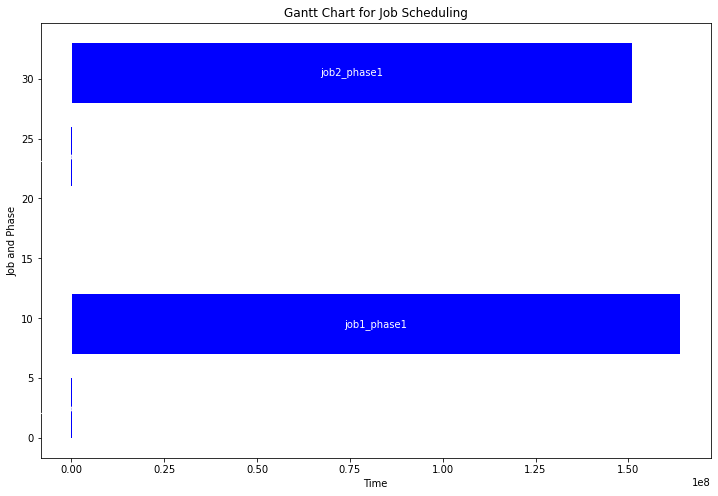

In [7]:
# Initialize Gantt chart for job scheduling visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Initialize the vertical position and height for the bars in the Gantt chart
y_pos = 0
height = 5

# Loop through each job and phase to plot the Gantt chart
for job, phase_list in phases.items():
    for i in range(len(phase_list)):
        # Get the start and end time from the pulp variables
        start_time = x[job, i].varValue
        end_time = y[job, i].varValue

        # Create a bar for the phase with the corresponding start and end time
        ax.broken_barh([(start_time, end_time - start_time)], (y_pos, height), facecolors='blue')

        # Annotate the bar with the phase information
        ax.text(start_time + (end_time - start_time) / 2, y_pos + height / 2, f"{job}_phase{i}", 
                horizontalalignment='center', verticalalignment='center', fontsize=10, color='white')

        # Increment the vertical position for the next bar
        y_pos += height + 2

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Job and Phase')
ax.set_title('Gantt Chart for Job Scheduling')

plt.show()


In [ ]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary

# Fonctions modèles pour estimer la bande passante maximale des tiers
def tier0_model(phase):
    return 100e6  # Exemple simple, à remplacer par un modèle plus complexe si nécessaire

def tier1_model(phase):
    return 200e6  # Exemple simple, à remplacer par un modèle plus complexe si nécessaire

# Données en entrée (représentation et phase_features)
# ... (Utiliser les données fournies précédemment)

# Initialisation du problème
prob = LpProblem("Job_Scheduling", LpMinimize)

# Variables de décision
x = {}  # Temps de début des phases
y = {}  # Temps de fin des phases
z = {}  # Choix du tier pour chaque phase
w = {}  # Bande passante attribuée à chaque phase
u = {}  # Utilisation du tier à un moment donné
n = {}  # Nombre de phases utilisant le même tier à un moment donné

# Boucle sur les jobs et les phases pour initialiser les variables
for job, phase_list in phases.items():
    for i, phase in enumerate(phase_list):
        x[job, i] = LpVariable(f"x_{job}_{i}", 0)
        y[job, i] = LpVariable(f"y_{job}_{i}", 0)
        for k in [0, 1]:  # Supposons qu'il y a deux tiers, 0 et 1
            z[job, i, k] = LpVariable(f"z_{job}_{i}_{k}", 0, 1, LpBinary)
            w[job, i, k] = LpVariable(f"w_{job}_{i}_{k}", 0)
            u[job, i, k] = LpVariable(f"u_{job}_{i}_{k}", 0, 1, LpBinary)

# Fonction objectif
prob += lpSum(y.values()), "Minimize_Max_EndTime"

# Ajout des contraintes
for job, phase_list in phases.items():
    for i, phase in enumerate(phase_list):
        # Contrainte: Chaque phase devrait commencer après la fin de la phase précédente
        if i > 0:
            prob += x[job, i] >= y[job, i - 1], f"StartAfterPrev_{job}_{i}"

        # Contrainte: Fin de la phase en fonction de la bande passante et du volume total
        total_volume = phase['read_volume'] + phase['write_volume']
        for k in [0, 1]:
            max_bandwidth = tier0_model(phase) if k == 0 else tier1_model(phase)
            prob += y[job, i] == x[job, i] + (total_volume / w[job, i, k]), f"EndTime_{job}_{i}_{k}"

        # Contrainte: Choix du tier
        prob += lpSum([z[job, i, k] for k in [0, 1]]) == 1, f"SingleTier_{job}_{i}"

        # Contrainte: Bande passante partagée si plusieurs phases utilisent le même tier
        for k in [0, 1]:
            max_bandwidth = tier0_model(phase) if k == 0 else tier1_model(phase)
            n[k] = lpSum([u[j, i, k] for j, phase_list in phases.items() for i in range(len(phase_list))])
            prob += w[job, i, k] == max_bandwidth / (n[k] + 1e-5), f"SharedBandwidth_{job}_{i}_{k}"

# Résolution du problème
prob.solve()

# Extraction et affichage des résultats
for job, phase_list in phases.items():
    print(f"Scheduling for {job}:")
    for i in range(len(phase_list)):
        print(f"  Phase {i}: Start at {x[job, i].varValue}, End at {y[job, i].varValue}")


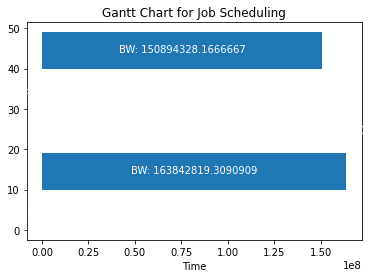

In [8]:
# It appears there is an issue with plotting the graph. Let's try again.
fig, ax = plt.subplots()

# Initialize the vertical position for the Gantt bars
y_position = 0

# Loop through each job and its phases to populate the Gantt chart
for job_key, phase_list in phases.items():
    for i in range(len(phase_list)):
        # Extract the start and end times for each phase from the optimization results
        start_time = x[job_key, i].varValue
        end_time = y[job_key, i].varValue

        # Draw a bar for each phase with the start and end times
        ax.broken_barh([(start_time, end_time - start_time)], (y_position, 9), facecolors=('tab:blue'))

        # Add text annotation for bandwidth (here, we are directly using the ioi_bw from the phase features for demonstration)
        bandwidth = phase_list[i]['ioi_bw']
        plt.annotate(f'BW: {bandwidth}', (start_time + (end_time - start_time) / 2, y_position + 4), 
                     color='white', ha='center')

        # Increment the y_position for the next bar
        y_position += 10

# Add some labels and title for better readability
ax.set_xlabel('Time')
ax.set_title('Gantt Chart for Job Scheduling')
plt.show()


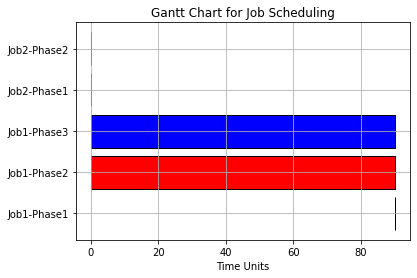

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data from Pulp output
job1_phases = {
    'Phase1': {'start': 0, 'end': x1_1.varValue},
    'Phase2': {'start': x1_1.varValue, 'end': y1_1.varValue},
    'Phase3': {'start': y1_1.varValue, 'end': y1_2.varValue}
}

job2_phases = {
    'Phase1': {'start': 0, 'end': x2_1.varValue},
    'Phase2': {'start': x2_1.varValue, 'end': y2_1.varValue},
}

# Prepare plot
fig, ax = plt.subplots()
y_labels = []
y_ticks = []

# Plot for job 1
y = 0
for phase, timing in job1_phases.items():
    ax.broken_barh([(timing['start'], timing['end'] - timing['start'])], (y-0.4, 0.8), facecolors='blue', edgecolor='black')
    y_labels.append(f"Job1-{phase}")
    y_ticks.append(y)
    y -= 1

# Plot for job 2
for phase, timing in job2_phases.items():
    ax.broken_barh([(timing['start'], timing['end'] - timing['start'])], (y-0.4, 0.8), facecolors='red', edgecolor='black')
    y_labels.append(f"Job2-{phase}")
    y_ticks.append(y)
    y -= 1

# Formatting plot
ax.set_yticks(y_ticks)
ax.set_yticklabels(reversed(y_labels))
ax.set_xlabel("Time Units")
plt.title("Gantt Chart for Job Scheduling")
plt.grid(True)
plt.show()
